In [1]:
%load_ext autoreload
%autoreload 2
# Set HuggingFace cache directory to scratch to save space.
import os
os.environ['HUGGINGFACE_HUB_CACHE'] = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
CACHE_DIR = '/scratch/' + os.environ['USER'] + '/huggingface_cache'
# Optional; can help when memory is tight.
# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("microsoft/phi-2", torch_dtype="auto", trust_remote_code=True).to('cuda')
tokenizer = AutoTokenizer.from_pretrained("microsoft/phi-2", trust_remote_code=True)
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [23]:
import numpy as np

"""
from transformers.activations import ACT2FN

class PhiMLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.activation_fn = ACT2FN[config.hidden_act]
        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.fc1(hidden_states)
        hidden_states = self.activation_fn(hidden_states)
        hidden_states = self.fc2(hidden_states)
        return hidden_states
"""

sum_log = [
    torch.zeros(10240, device='cuda') for _ in range(32)
]
sum_square_log = [
    torch.zeros(10240, device='cuda') for _ in range(32)
]
count = [
    0 for _ in range(32)
]


class LoggingMLP(torch.nn.Module):
    def __init__(self, mlp, id):
        super().__init__()
        
        self.mlp = mlp
        self.id = id
    
    def forward(self, hidden_states: torch.Tensor):
        
        pre_activation = self.mlp.fc1(hidden_states)
        activation = self.mlp.activation_fn(pre_activation)
        
        i = self.id
        sum_log[i] += activation.sum(dim=(0, 1))
        sum_square_log[i] += (activation ** 2).sum(dim=(0, 1))
        count[i] += activation.shape[0] * activation.shape[1] # number of tokens it's seen
        
        return self.mlp.fc2(activation)
    

In [11]:
# replace MLP layers
original_mlps = [model.model.layers[i].mlp for i in range(len(model.model.layers))]

In [7]:
import json

data = json.load(open("/scratch/gsk6me/pubmedqa/data/pqaa_dev_set.json"))


In [24]:
for mlp_i in range(len(model.model.layers)):
    model.model.layers[mlp_i].mlp = LoggingMLP(original_mlps[mlp_i], mlp_i)

In [26]:
tokens = tokenizer(data['25344367']['QUESTION'], return_tensors='pt').to('cuda')
_ = model(**tokens)

In [32]:
variance = (sum_square_log[0] - sum_log[0]**2)/count[0]

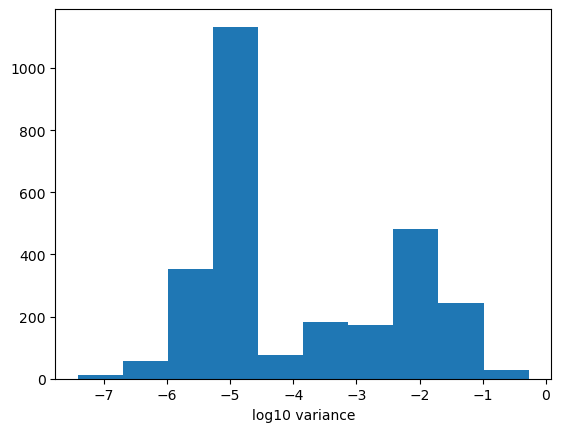

In [34]:
import matplotlib.pyplot as plt

plt.hist(variance.log10().detach().cpu().numpy())
plt.xlabel("log10 variance")
plt.show()
